#### Importation des Librairies

In [1]:
from sklearn.model_selection import train_test_split

In [2]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 2650, done.
remote: Counting objects: 100% (2650/2650), done.
remote: Compressing objects: 100% (2311/2311), done.
remote: Total 2650 (delta 505), reused 1389 (delta 306), pack-reused 0
Receiving objects: 100% (2650/2650), 34.02 MiB | 30.99 MiB/s, done.
Resolving deltas: 100% (505/505), done.
Note: switching to '400d68abbccda2f0f6609e3a924467718b144233'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false



In [3]:
!pip install -Uqr models/official/requirements.txt

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cubinlinker, which is not installed.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 23.8.0 requires ptxcompiler, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
beatrix-jupyterlab 2023.128.151533 requires jupyterlab~=3.6.0, but you have jupyterlab 4.1.6 which is incompatible.
cloud-tpu-client 0.10 requires google-api-python-client==1.8.0, but you have google-api-python-client 2.129.0 which is incompatible.
cudf 23.8.0 requires cuda-python<12.0a0,>=11.7.1, but you have cuda-python 12.4.0 which is incompatible.
cudf 23.8.0 requires pandas<1.6.0dev0,>=1.3, but you have pandas 2.2.2 

In [4]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

2024-05-14 20:33:38.012035: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-14 20:33:38.012163: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-14 20:33:38.289523: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our Tens

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/NLP

Mounted at /content/drive

/content/drive/MyDrive/NLP


#### preprocesssing function

In [ ]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...

[nltk_data]   Unzipping corpora/stopwords.zip.


True

#### Preparation Des Données

##### Netoyage des Tweets

In [ ]:
from unicodedata import normalize
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

def analyser(x):
    x = str(x)

    x = re.sub(r'<[^>]+>', '', x) # Suppression de balises HTML 

    x = re.sub(r'http\S+', '', x) # Supression des liens (URLs)

    x = normalize('NFC', x).encode('ascii', 'ignore').decode('utf-8', 'ignore')

    x = x.lower() # Minuscule

    x = re.sub("[^a-z]", " ", x) # Suppression des non-mots (ponctuation)
    
    x = x.split()

    stop_words = set(stopwords.words('english')) 
    x = [word for word in x if word not in stop_words]  #Suppression des mots vide 


    stemmer = PorterStemmer() # Radicalisation de mots 
    x = [stemmer.stem(word) for word in x]

    return " ".join(x).strip()

analyser('hysÂ·terÂ·iÂ·a [ hi stÃ©eree É™ ] - a state of extreme emotion.')   #Example

'hysteria hi stere state extrem emot'

##### Importation de données

In [7]:
import pandas as pd
import os

encodings = ['utf-8', 'ISO-8859-1', 'cp1252', 'utf-8']

# Loop through each encoding and attempt to read the CSV file
for encoding in encodings:
    try:
        df = pd.read_csv('/kaggle/input/traindataset/train_tweets (1).csv', encoding=encoding)
        print("CSV file read successfully with encoding:", encoding)
        break  # Exit the loop if successful
    except UnicodeDecodeError:
        print("Error reading CSV file with encoding:", encoding)
df[["X1","X6"]]

Error reading CSV file with encoding: utf-8
CSV file read successfully with encoding: ISO-8859-1


,X1,X6
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,4,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...


In [ ]:
# df = pd.DataFrame(df)


##### Check for the distribution

In [ ]:
# df.head()

##### Appliquer la fonction sur la base de données

In [ ]:
df.X6= df.X6.apply(lambda x : analyser(x))

In [ ]:
df.to_csv("cleaned.csv",index = False)

In [ ]:
# df

In [8]:
import pandas as pd
import os

encodings = ['utf-8', 'ISO-8859-1', 'cp1252', 'utf-8']

# Loop through each encoding and attempt to read the CSV file
for encoding in encodings:
    try:
        clean = pd.read_csv('/kaggle/input/datacleaned/cleaned.csv', encoding=encoding)
        print("CSV file read successfully with encoding:", encoding)
        break  # Exit the loop if successful
    except UnicodeDecodeError:
        print("Error reading CSV file with encoding:", encoding)
clean

CSV file read successfully with encoding: utf-8


,X1,X6
0,0,switchfoot awww bummer shoulda got david carr ...
1,0,upset updat facebook text might cri result sch...
2,0,kenichan dive mani time ball manag save rest g...
3,0,whole bodi feel itchi like fire
4,0,nationwideclass behav mad see
...,...,...
1599995,4,woke school best feel ever
1599996,4,thewdb com cool hear old walt interview
1599997,4,readi mojo makeov ask detail
1599998,4,happi th birthday boo alll time tupac amaru sh...


##### **Comparaisen Avnat netoyage et Apres**

In [11]:
pd.DataFrame({"Raw Tweet": df.X6,"After Preprocessing" : clean.X6}).head(20)

,Raw Tweet,After Preprocessing
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot awww bummer shoulda got david carr ...
1,is upset that he can't update his Facebook by ...,upset updat facebook text might cri result sch...
2,@Kenichan I dived many times for the ball. Man...,kenichan dive mani time ball manag save rest g...
3,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire
4,"@nationwideclass no, it's not behaving at all....",nationwideclass behav mad see
5,@Kwesidei not the whole crew,kwesidei whole crew
6,Need a hug,need hug
7,@LOLTrish hey long time no see! Yes.. Rains a...,loltrish hey long time see ye rain bit bit lol...
8,@Tatiana_K nope they didn't have it,tatiana k nope
9,@twittera que me muera ?,twittera que muera


##### Recifation Labels 

In [6]:
df=clean
df.X1 = df.X1.apply(lambda x : 1 if x==4 else 0)

In [7]:
df

,X1,X6
0,0,switchfoot awww bummer shoulda got david carr ...
1,0,upset updat facebook text might cri result sch...
2,0,kenichan dive mani time ball manag save rest g...
3,0,whole bodi feel itchi like fire
4,0,nationwideclass behav mad see
...,...,...
1599995,1,woke school best feel ever
1599996,1,thewdb com cool hear old walt interview
1599997,1,readi mojo makeov ask detail
1599998,1,happi th birthday boo alll time tupac amaru sh...


#### **Modelisation**

##### Deviser la base de données en : entrainement valdiation et test

In [8]:
import numpy as np


train_df,remaining = train_test_split(df,random_state=42,train_size=0.75,stratify=df.X1.values)
valid_df,test_df = train_test_split(remaining,random_state=42,train_size=0.4,stratify=remaining.X1.values)
train_df.shape,valid_df.shape,test_df.shape

((1200000, 2), (160000, 2), (240000, 2))

#### Convert to tensorflow dataset

In [9]:
with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((train_df.X6.astype(str).values, train_df.X1.astype(int).values))
  valid_data = tf.data.Dataset.from_tensor_slices((valid_df.X6.astype(str).values, valid_df.X1.astype(int).values))
  test_data = tf.data.Dataset.from_tensor_slices((test_df.X6.astype(str).values, test_df.X1.astype(int).values))

  for text, label in train_data.take(1):
    print(text)
    print(label)

tf.Tensor(b'ya go messi day cg turn turquois petit black cheap glitter', shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int64)


##### Telecharger le model Bert et construire le vocabulaire

In [2]:
nltk.download('punkt')  

tweets = clean.X6.tolist()


tokenized_tweets = [nltk.word_tokenize(str(tweet)) for tweet in tweets]

tweet_lengths = [len(tokens) for tokens in tokenized_tweets]

import numpy as np
max_sequence_length = np.quantile(tweet_lengths,[0.5,0.75,0.9,1]) 

print("Max Sequence Length:", max_sequence_length) # nombre de mots par phrase

Max Sequence Length: [ 7. 10. 13. 50.]


In [10]:
label_list = [0, 1]
max_seq_length = 16
train_batch_size = 256

bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",
                            trainable=True)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
tokenizer.wordpiece_tokenizer.tokenize('hysÂ·terÂ·iÂ·a [ hi stÃ©eree É™ ] - a state of extreme emotion.')

['[UNK]',
 '[',
 'hi',
 '[UNK]',
 '[UNK]',
 ']',
 '-',
 'a',
 'state',
 'of',
 'extreme',
 'emotion',
 '##.']

In [ ]:
tokenizer.wordpiece_tokenizer.tokenize(analyser('hysÂ·terÂ·iÂ·a [ hi stÃ©eree É™ ] - a state of extreme emotion.'))

['hysteria', 'hi', 'ste', '##re', 'state', 'ex', '##tre', '##m', 'em', '##ot']

#### Word embedding

vectorisation des mots

In [ ]:
tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize(analyser('hysÂ·terÂ·iÂ·a [ hi stÃ©eree É™ ] - a state of extreme emotion.')))

[29004, 7632, 26261, 2890, 2110, 4654, 7913, 2213, 7861, 4140]

##### Creation : Mask, Id & Type pour Bert Model

In [11]:
def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  example = classifier_data_lib.InputExample(guid = None,
                                            text_a = text.numpy(),
                                            text_b = None,
                                            label = label.numpy())
  feature = classifier_data_lib.convert_single_example(0, example, label_list,
                                    max_seq_length, tokenizer)

  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

In [12]:
def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text, label],
                                Tout=[tf.int32, tf.int32, tf.int32, tf.int32])

  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])

  x = {
        'input_word_ids': input_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
    }
  return (x, label_id)

In [13]:
with tf.device('/cpu:0'):
  # train
  train_data = (train_data.map(to_feature_map,
                              num_parallel_calls=tf.data.experimental.AUTOTUNE)
                          .cache()
                          .shuffle(1000)
                          .batch(256, drop_remainder=True)
                          .prefetch(tf.data.experimental.AUTOTUNE))

  # valid
  valid_data = (valid_data.map(to_feature_map,
                            num_parallel_calls=tf.data.experimental.AUTOTUNE)
                          .batch(256, drop_remainder=True)
                          .prefetch(tf.data.experimental.AUTOTUNE))

  test_data = (test_data.map(to_feature_map).batch(1))

##### Check if the code worked well

In [14]:
train_data.element_spec

({'input_word_ids': TensorSpec(shape=(256, 32), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(256, 32), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(256, 32), dtype=tf.int32, name=None)},
 TensorSpec(shape=(256,), dtype=tf.int32, name=None))

In [15]:
test_data.element_spec

({'input_word_ids': TensorSpec(shape=(None, 32), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(None, 32), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(None, 32), dtype=tf.int32, name=None)},
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [16]:
train_data.as_numpy_iterator().next()

({'input_word_ids': array([[  101, 11333,  4430, ...,     0,     0,     0],
         [  101,  2310, 13871, ...,     0,     0,     0],
         [  101,  2145,  4687, ...,     0,     0,     0],
         ...,
         [  101, 27571,  9541, ...,     0,     0,     0],
         [  101,  2444,  2600, ...,     0,     0,     0],
         [  101, 13360, 23644, ...,     0,     0,     0]], dtype=int32),
  'input_mask': array([[1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         ...,
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0]], dtype=int32),
  'input_type_ids': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=int32)},
 array([0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 1, 1, 

In [ ]:
test_data.as_numpy_iterator().next()

({'input_word_ids': array([[  101,  6874,  2094,  2057, 22499,  2213, 15876,  2078,   102,
              0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0]], dtype=int32),
  'input_mask': array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32),
  'input_type_ids': array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)},
 array([1], dtype=int32))

##### Definition du model 

en ajoutant une couche  

In [ ]:
def create_model():
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                      name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                  name="input_mask")
  input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                  name="input_type_ids")

  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])

  drop = tf.keras.layers.Dropout(0.5)(pooled_output)
  dense = tf.keras.layers.Dense(128, activation="relu")(drop)
  drop2 = tf.keras.layers.Dropout(0.5)(dense)
  output = tf.keras.layers.Dense(1, activation="sigmoid", name="output")(drop2)

  model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': input_type_ids
    },
    outputs=output)
  return model

##### Compiling the Model

In [ ]:
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
                     loss=tf.keras.losses.BinaryCrossentropy(),
                     metrics=[tf.keras.metrics.AUC()])
model.summary()

Model: "model"

__________________________________________________________________________________________________

 Layer (type)                Output Shape                 Param #   Connected to                  


 input_word_ids (InputLayer  [(None, 32)]                 0         []                            

 )                                                                                                

                                                                                                  

 input_mask (InputLayer)     [(None, 32)]                 0         []                            

                                                                                                  

 input_type_ids (InputLayer  [(None, 32)]                 0         []                            

 )                                                                                                

                                                                                   

##### Visualisation de l'architecture

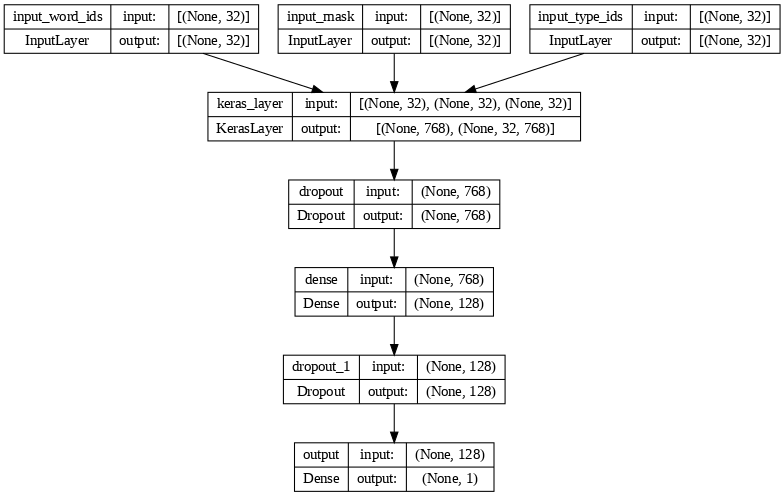

In [ ]:
tf.keras.utils.plot_model(model=model,show_shapes=True,dpi=76)

##### Train the model

In [1]:
epochs=2
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=epochs,
                    verbose=1)

9375/9375 [==============================] - 11617s 1s/step - loss: 0.4594 - auc: 0.8650 - val_loss: 0.4244 - val_auc: 0.8861
Epoch 2/2
9375/9375 [==============================] - 11608s 1s/step - loss: 0.4060 - auc: 0.8968 - val_loss: 0.4263 - val_auc: 0.8876


##### Saving the File

In [ ]:
model.save("aymenmodel.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

  saving_api.save_model(


##### Predictions

In [ ]:
test_data

<_BatchDataset element_spec=({'input_word_ids': TensorSpec(shape=(None, 32), dtype=tf.int32, name=None), 'input_mask': TensorSpec(shape=(None, 32), dtype=tf.int32, name=None), 'input_type_ids': TensorSpec(shape=(None, 32), dtype=tf.int32, name=None)}, TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [17]:
custom_objects = {'KerasLayer': bert_layer}

from tensorflow.keras.models import load_model

model = load_model('/kaggle/input/bertsaved/aymenmodel.h5', custom_objects=custom_objects)

In [ ]:
# num_samples = len(test_data)
# half_num_samples = num_samples // 2

# first_half = test_data.take(half_num_samples)


# # # Predict for the first half
# pred = model.predict(first_half)



120000/120000 [==============================] - 1161s 10ms/step


In [ ]:
second_half = test_data.skip(half_num_samples)

#Predict for the second half
pred_second_half = model.predict(second_half)

# Concatenate the predictions if needed
pred_combined = np.concatenate([pred, pred_second_half], axis=0)

In [18]:
pred = model.predict(test_data)
pred

240000/240000 [==============================] - 1834s 8ms/step


array([[0.9951302 ],
       [0.5760659 ],
       [0.7185708 ],
       ...,
       [0.79311085],
       [0.83573467],
       [0.02841634]], dtype=float32)

In [19]:
probas = [pred[0] for pred in pred]

In [20]:
classes = [1 if proba > 0.5 else 0 for proba in probas]
preds = pd.DataFrame({'classes': classes})

# Save the DataFrame to a CSV file
preds.to_csv("preds.csv", index=False)

#### Evalusation 
Accuracy 
sensibilité
precision etc...

In [2]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

print(f"Accuracy Scorce is : {accuracy_score(test_df.X1.values, classes)}")
print("-"*20)
print(classification_report(test_df.X1.values, classes))


Accuracy Scorce is : 0.8005916666666667
--------------------
              precision    recall  f1-score   support

           0       0.79      0.82      0.80    120000
           1       0.81      0.79      0.80    120000

    accuracy                           0.80    240000
   macro avg       0.80      0.80      0.80    240000
weighted avg       0.80      0.80      0.80    240000

